Today, I am going to work with Cricket dataset. This dataset belongs to Indian Premier League (IPL) that took place in 2018. 
Most of the people are aware that besides being the name of an insect, it is also a sport 
which is dominant in Indian subcontinent region. More about cricket can he read at https://en.wikipedia.org/wiki/Cricket
    
The dataset I will be working with was obtained from 
https://data.world/aliraza/indian-premier-league-2018-batting-and-bowling-data .

I will attempt to cluster the data into three groups which is All-Rounders, Batsmen and Bowler
and verify how good the algorithm is able to cluster the data into these groups. For this I will apply Clustering Algorithm from Unsupervised learning. I will attempt to apply Agglomerative Clustering and K-means Algorithms and compare the results.

In [369]:
import pandas as pd
import numpy as np 

import seaborn as sns
import matplotlib.pyplot as plt

import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import accuracy_score, confusion_matrix

from sklearn.model_selection import train_test_split

### Exploratory Data Analysis

In [370]:
ipl = pd.read_csv('cricket.csv')
ipl.head(10)

,PLAYER,Mat.x,Inns.x,NO,Runs.x,HS,Avg.x,BF,SR.x,X100,...,Ov,Runs.y,Wkts,BBI,Avg.y,Econ,SR.y,X4w,X5w,y
0,Aaron Finch,10,9,1,134,46,16.75,100,134.00,0,...,0.0,0,0,0,0,0.00,0,0,0,0
1,AB de Villiers,12,11,2,480,90,53.33,275,174.54,0,...,0.0,0,0,0,0,0.00,0,0,0,0
2,Abhishek Sharma,3,3,2,63,46,63,33,190.90,0,...,0.0,0,0,0,0,0.00,0,0,0,0
3,Ajinkya Rahane,15,14,1,370,65,28.46,313,118.21,0,...,0.0,0,0,0,0,0.00,0,0,0,0
4,Alex Hales,6,6,0,148,45,24.66,118,125.42,0,...,0.0,0,0,0,0,0.00,0,0,0,0
5,Ambati Rayudu,16,16,2,602,100,43,402,149.75,1,...,0.0,0,0,0,0,0.00,0,0,0,0
6,Andre Russell,16,14,3,316,88,28.72,171,184.79,0,...,37.5,355,13,0,27.3,9.38,17.46,0,0,0
7,Andrew Tye,14,8,2,32,14,5.33,38,84.21,0,...,56.0,448,24,0,18.66,8.00,14,3,0,0
8,Axar Patel,9,8,2,80,19,13.33,69,115.94,0,...,26.0,218,3,0,72.66,8.38,52,0,0,0
9,Ben Cutting,9,6,2,96,37,24,58,165.51,0,...,17.0,168,2,0,84,9.88,51,0,0,0


In [371]:
ipl.columns

Index(['PLAYER', 'Mat.x', 'Inns.x', 'NO', 'Runs.x', 'HS', 'Avg.x', 'BF',
       'SR.x', 'X100', 'X50', 'X4s', 'X6s', 'Mat.y', 'Inns.y', 'Ov', 'Runs.y',
       'Wkts', 'BBI', 'Avg.y', 'Econ', 'SR.y', 'X4w', 'X5w', 'y'],
      dtype='object')

#### a function to generate category based on their match/innings stats. This will be used to compare the results obtained by the algorithm to check the accuracy.

In [372]:

def categorize(m_bat,i_bat, m_bowl, i_bowl):
    if m_bat > .5*i_bat and m_bowl > .5*i_bowl:
        return 'Allrounder'
    elif m_bat > .5*i_bat:
        return 'Batsman'
    else: return 'Bowler'


players = ipl[['PLAYER','Mat.x', 'Inns.x', 'Mat.y', 'Inns.y']].copy()
players['category'] = players.apply(lambda x: categorize(x['Mat.x'], x['Inns.x'],x['Mat.y'], x['Inns.y']), axis=1)
players.head(10)

,PLAYER,Mat.x,Inns.x,Mat.y,Inns.y,category
0,Aaron Finch,10,9,0,0,Batsman
1,AB de Villiers,12,11,0,0,Batsman
2,Abhishek Sharma,3,3,0,0,Batsman
3,Ajinkya Rahane,15,14,0,0,Batsman
4,Alex Hales,6,6,0,0,Batsman
5,Ambati Rayudu,16,16,0,0,Batsman
6,Andre Russell,16,14,16,15,Allrounder
7,Andrew Tye,14,8,14,14,Allrounder
8,Axar Patel,9,8,9,8,Allrounder
9,Ben Cutting,9,6,9,7,Allrounder


The raw dataset uses a cryptic naming for columns. 
#### Being a cricket enthusiast, I am aware of most of the columns so I will first attempt to rename the columns to give them a meaningful name and also delete the columns 
    - that don't hold much significance (y, BBI, X4w, X5w, X100, X50, X4s, X6s) 
#### I have attempted to rename the left columns to give them meaningful names.


In [373]:
ipl = ipl.drop(['PLAYER','y','BBI', 'X4w', 'X5w','X100', 'X50', 'X4s', 'X6s'], axis=1)
ipl = ipl.rename(columns ={"Mat.x": "matches_played_bat", 
                "Inns.x": "bat_innings", "NO":"not_out", "Runs.x":"runs", 
                "HS":"highest_score", "Avg.x": "bat_average", "BF": "balls_faced", "SR.x": "bat_score_rate", 
                  "X100": "centuries", "X50":"half_centuries", "X4s": "boundaries", "X6s": "sixes", 
                  "Inns.y":"bowled_innings", "Ov":"overs_bowled","Runs.y":"runs_conceded", "Wkts":"wickets",
                  "Avg.y":"bowl_average", "Econ":"bowl_economy", "SR.y":"bowl_score_rate","Mat.y":"macthes_played_bowl"})
ipl.head(10)

,matches_played_bat,bat_innings,not_out,runs,highest_score,bat_average,balls_faced,bat_score_rate,macthes_played_bowl,bowled_innings,overs_bowled,runs_conceded,wickets,bowl_average,bowl_economy,bowl_score_rate
0,10,9,1,134,46,16.75,100,134.00,0,0,0.0,0,0,0,0.00,0
1,12,11,2,480,90,53.33,275,174.54,0,0,0.0,0,0,0,0.00,0
2,3,3,2,63,46,63,33,190.90,0,0,0.0,0,0,0,0.00,0
3,15,14,1,370,65,28.46,313,118.21,0,0,0.0,0,0,0,0.00,0
4,6,6,0,148,45,24.66,118,125.42,0,0,0.0,0,0,0,0.00,0
5,16,16,2,602,100,43,402,149.75,0,0,0.0,0,0,0,0.00,0
6,16,14,3,316,88,28.72,171,184.79,16,15,37.5,355,13,27.3,9.38,17.46
7,14,8,2,32,14,5.33,38,84.21,14,14,56.0,448,24,18.66,8.00,14
8,9,8,2,80,19,13.33,69,115.94,9,8,26.0,218,3,72.66,8.38,52
9,9,6,2,96,37,24,58,165.51,9,7,17.0,168,2,84,9.88,51


In [374]:
ipl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   matches_played_bat   143 non-null    int64  
 1   bat_innings          143 non-null    int64  
 2   not_out              143 non-null    int64  
 3   runs                 143 non-null    int64  
 4   highest_score        143 non-null    int64  
 5   bat_average          143 non-null    object 
 6   balls_faced          143 non-null    int64  
 7   bat_score_rate       143 non-null    float64
 8   macthes_played_bowl  143 non-null    int64  
 9   bowled_innings       143 non-null    int64  
 10  overs_bowled         143 non-null    float64
 11  runs_conceded        143 non-null    int64  
 12  wickets              143 non-null    int64  
 13  bowl_average         143 non-null    object 
 14  bowl_economy         143 non-null    float64
 15  bowl_score_rate      143 non-null    obj

In [375]:
len(players)

143

As we can see that we have 143 players' information and 14 columns that defines players' performance.
Also, there is no duplication of records which means each row corresponds to a unique cricket player.

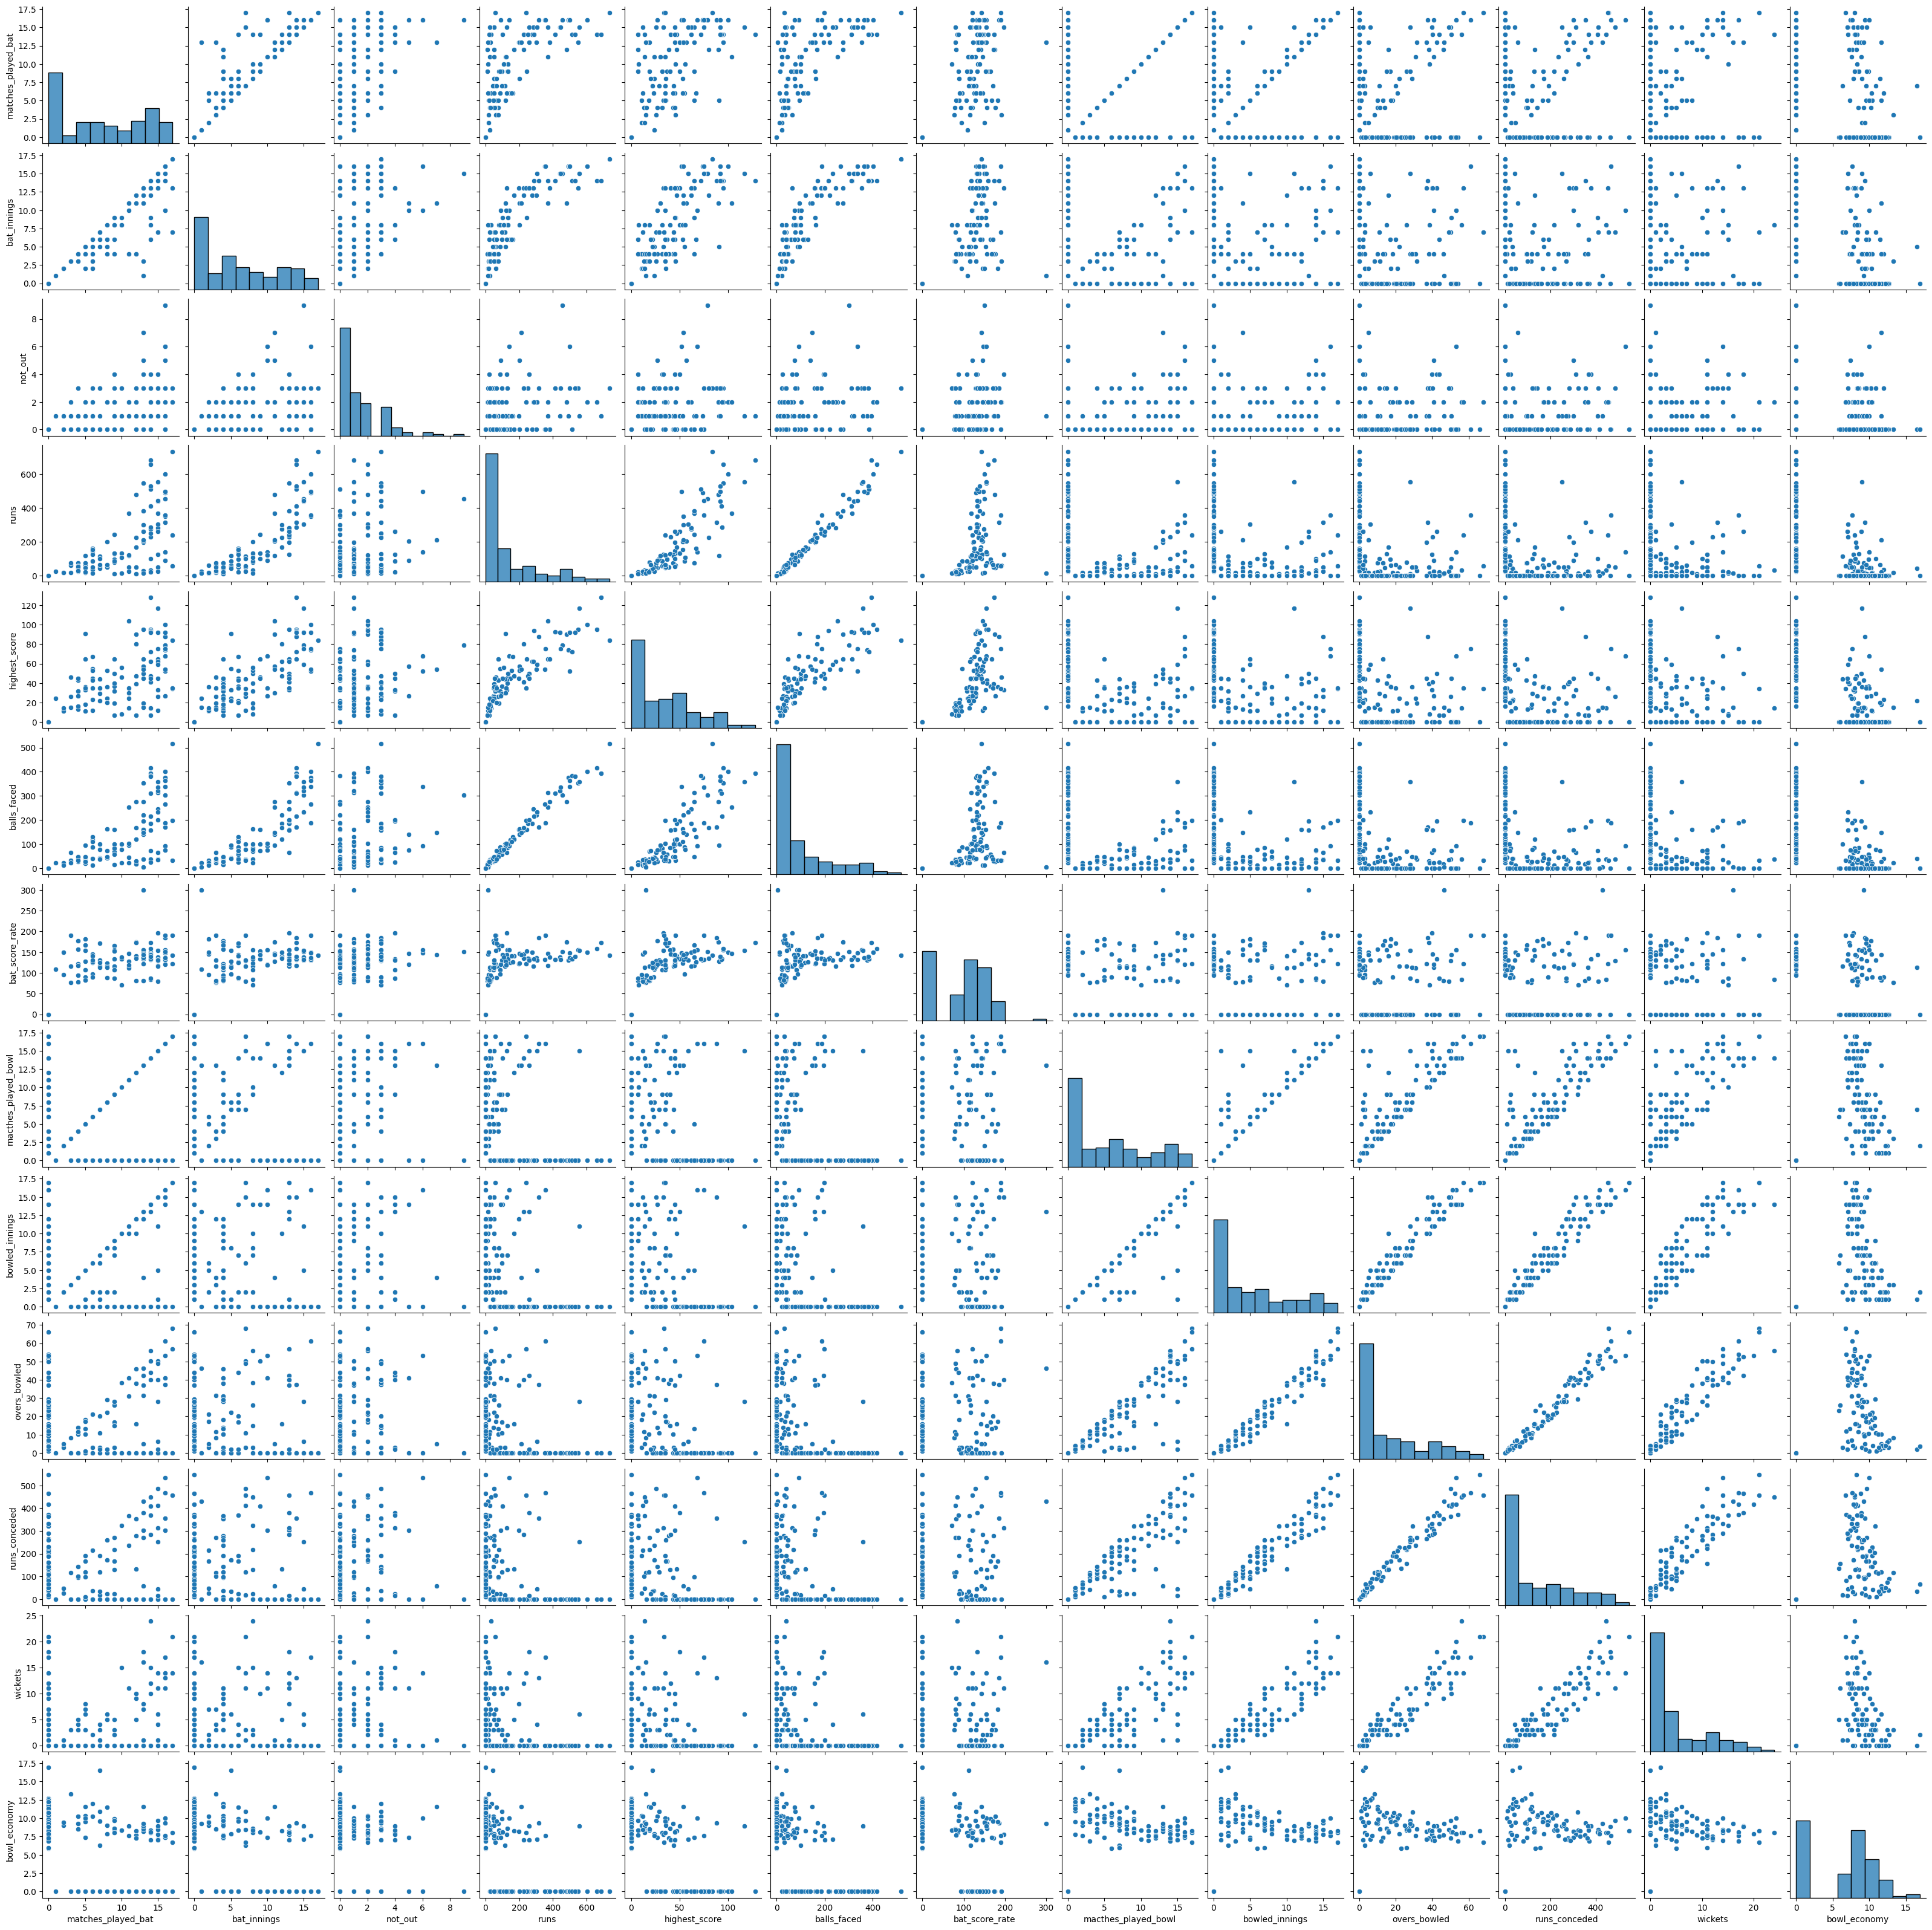

In [333]:
sns.pairplot(ipl) 
plt.show() 

#### We will inspect the columns with 'object' datatype and check for unique values.

In [379]:
print(ipl.bat_average.unique())
print(ipl.bowl_average.unique())
print(ipl.bowl_score_rate.unique())

['16.75' '53.33' '63' '28.46' '24.66' '43' '28.72' '5.33' '13.33' '24'
 '16.33' '6.5' '21.16' '25' '40.88' '32.73' '46' '8.5' '26.2' '12.6'
 '5.66' '16.42' '13' '37' '16.66' '21.75' '49.8' '35.25' '29.38' '32.4'
 '17' '14.08' '9.66' '28.88' '60' '19' '22.91' '30' '12.25' '3' '54.8'
 '36' '52.5' '25.08' '-' '14' '22.8' '54.91' '20' '13.75' '25.2' '25.81'
 '15.66' '24.75' '12' '10.5' '19.25' '9' '12.5' '75.83' '23.38' '30.6'
 '6.75' '27.22' '25.12' '25.11' '11.8' '12.75' '17.8' '7.25' '52.61'
 '21.93' '23.83' '13.5' '31.5' '10.2' '21.72' '39.64' '38.23' '4.33'
 '17.33' '37.36' '33.83' '8.8' '22.31' '37.08' '36.57' '26' '7.66' '53'
 '48.18' '21.66' '15.25' '10.83' '0']
['0' '27.3' '18.66' '72.66' '84' '37.87' '39.33' '18.8' '47.66' '23.75'
 '64.5' '38.33' '19' '25.25' '27.8' '-' '38.07' '26.4' '38.57' '21.16'
 '23.85' '44.18' '21.66' '28.36' '23.66' '40' '24.53' '108' '32.33' '47'
 '33.36' '11' '29.42' '28.83' '21.8' '41' '27.54' '32.57' '41.83' '26.93'
 '54' '21.45' '27.47' '52.2' '19.66

#### There are some unknowns in some cells which are marked as '-'. At initial glance, they seemed to be missing value but a better look makes me realize they are the values where the input is supposed to be 0. So, I have replaced '-' with 0, without compromising on the quality of data.

In [380]:
ipl['bat_average'].replace('-', 0, inplace=True)
ipl['bat_average'] = ipl.bat_average.astype(float)

In [381]:
ipl['bowl_average'].replace('-', 0.0, inplace=True)
ipl['bowl_average'] = ipl.bowl_average.astype(float)

In [382]:
ipl['bowl_score_rate'].replace('-', 0.0, inplace=True)
ipl['bowl_score_rate'] = ipl.bowl_score_rate.astype(float)

In [389]:
ipl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Data columns (total 16 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   matches_played_bat   143 non-null    int64  
 1   bat_innings          143 non-null    int64  
 2   not_out              143 non-null    int64  
 3   runs                 143 non-null    int64  
 4   highest_score        143 non-null    int64  
 5   bat_average          143 non-null    float64
 6   balls_faced          143 non-null    int64  
 7   bat_score_rate       143 non-null    float64
 8   macthes_played_bowl  143 non-null    int64  
 9   bowled_innings       143 non-null    int64  
 10  overs_bowled         143 non-null    float64
 11  runs_conceded        143 non-null    int64  
 12  wickets              143 non-null    int64  
 13  bowl_average         143 non-null    float64
 14  bowl_economy         143 non-null    float64
 15  bowl_score_rate      143 non-null    flo

In [390]:
ipl.corr()

,matches_played_bat,bat_innings,not_out,runs,highest_score,bat_average,balls_faced,bat_score_rate,macthes_played_bowl,bowled_innings,overs_bowled,runs_conceded,wickets,bowl_average,bowl_economy,bowl_score_rate
matches_played_bat,1.000000,0.916473,0.621347,0.723136,0.744583,0.641660,0.739628,0.777217,0.116253,0.053495,0.023220,0.004212,-0.003295,-0.208734,-0.444839,-0.176038
bat_innings,0.916473,1.000000,0.562398,0.872369,0.854022,0.729320,0.888250,0.713870,-0.090843,-0.165696,-0.196373,-0.219665,-0.193785,-0.339860,-0.567797,-0.323847
not_out,0.621347,0.562398,1.000000,0.396723,0.409319,0.612632,0.397643,0.495803,0.160959,0.078428,0.040074,0.050595,0.025118,0.002736,-0.148006,-0.001120
runs,0.723136,0.872369,0.396723,1.000000,0.884152,0.783455,0.990385,0.555502,-0.277629,-0.317310,-0.322647,-0.342976,-0.304923,-0.393926,-0.606136,-0.397493
highest_score,0.744583,0.854022,0.409319,0.884152,1.000000,0.830132,0.874033,0.739197,-0.280735,-0.327453,-0.344854,-0.361960,-0.337882,-0.408731,-0.659862,-0.408983
bat_average,0.641660,0.729320,0.612632,0.783455,0.830132,1.000000,0.770751,0.715636,-0.273719,-0.337724,-0.354767,-0.363427,-0.345665,-0.341533,-0.545547,-0.355668
balls_faced,0.739628,0.888250,0.397643,0.990385,0.874033,0.770751,1.000000,0.546344,-0.295080,-0.343517,-0.348025,-0.369168,-0.328013,-0.418468,-0.627006,-0.422098
bat_score_rate,0.777217,0.713870,0.495803,0.555502,0.739197,0.715636,0.546344,1.000000,-0.061619,-0.111514,-0.144184,-0.152878,-0.164780,-0.191198,-0.472677,-0.178640
macthes_played_bowl,0.116253,-0.090843,0.160959,-0.277629,-0.280735,-0.273719,-0.295080,-0.061619,1.000000,0.938013,0.890347,0.885476,0.837922,0.529268,0.545834,0.615843
bowled_innings,0.053495,-0.165696,0.078428,-0.317310,-0.327453,-0.337724,-0.343517,-0.111514,0.938013,1.000000,0.977588,0.973544,0.922489,0.546744,0.495144,0.635538


lastly, we need to scale our data before we can apply our algorithms to the dataset, to prevent us from getting erroneuous reults.

In [391]:
from sklearn.preprocessing import StandardScaler
stdsc = StandardScaler()
ipl_a = stdsc.fit_transform(ipl)
ipl_scaled = pd.DataFrame(ipl_a,columns = ipl.columns)
ipl_scaled.head(5)

,matches_played_bat,bat_innings,not_out,runs,highest_score,bat_average,balls_faced,bat_score_rate,macthes_played_bowl,bowled_innings,overs_bowled,runs_conceded,wickets,bowl_average,bowl_economy,bowl_score_rate
0,0.448003,0.544917,-0.155060,0.009438,0.403235,-0.017361,0.041480,0.610442,-0.997548,-0.932704,-0.855674,-0.896204,-0.786099,-0.938663,-1.320607,-0.98048
1,0.778232,0.909896,0.460873,1.988078,1.784377,2.144834,1.501449,1.215811,-0.997548,-0.932704,-0.855674,-0.896204,-0.786099,-0.938663,-1.320607,-0.98048
2,-0.707798,-0.550021,0.460873,-0.396584,0.403235,2.716414,-0.517479,1.460109,-0.997548,-0.932704,-0.855674,-0.896204,-0.786099,-0.938663,-1.320607,-0.98048
3,1.273575,1.457365,-0.155060,1.359030,0.999637,0.674802,1.818470,0.374656,-0.997548,-0.932704,-0.855674,-0.896204,-0.786099,-0.938663,-1.320607,-0.98048
4,-0.212455,-0.002552,-0.770993,0.089498,0.371846,0.450189,0.191648,0.482320,-0.997548,-0.932704,-0.855674,-0.896204,-0.786099,-0.938663,-1.320607,-0.98048


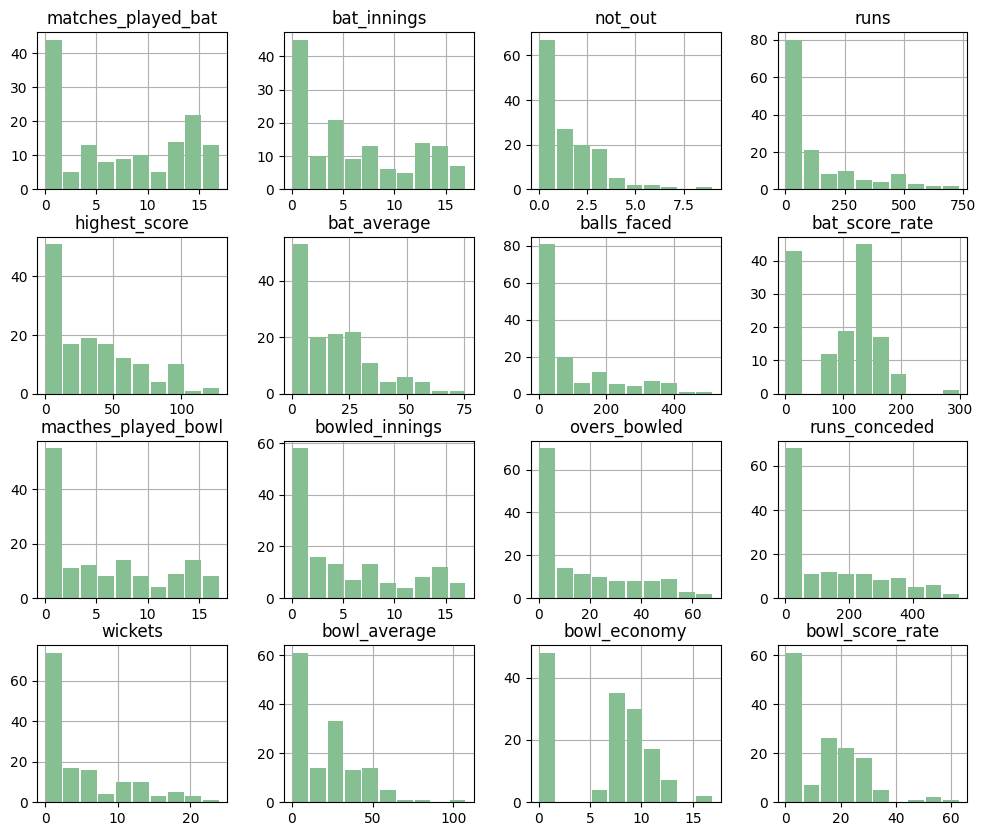

In [392]:
h = ipl.hist(figsize=(12,10), color='#86bf91', zorder=2, rwidth=0.9)
plt.show()

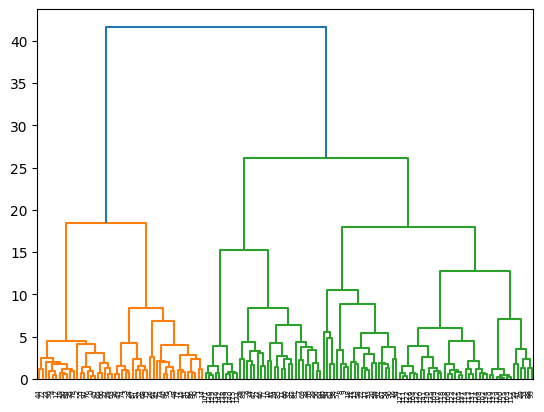

In [388]:
d = shc.dendrogram(shc.linkage(ipl_scaled,method='ward'))

### Creating Unsupervised Machine Learning Models using Agglomerative Clustering and K Means.

In [393]:
model = AgglomerativeClustering(n_clusters=3, metric='manhattan', linkage='complete')  
model.fit(ipl_scaled)
print(model.labels_)

[1 1 1 1 1 1 2 0 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 0 0 1 2 1 1 1 0 0 2 0 1 1
 1 2 0 1 0 1 1 1 1 2 2 1 0 1 1 1 0 0 1 0 0 0 0 0 1 2 1 0 1 1 0 1 0 2 2 1 1
 1 1 1 1 1 2 2 0 1 0 1 0 1 1 0 2 1 1 0 0 2 1 0 1 2 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [394]:
import itertools

def label_permute_compare(ytdf,yp,n=3):
    permutations = list(itertools.permutations(range(n)))
    max_acc = 0
    best = ()
    ytdf_i, uniques = pd.factorize(np.array(ytdf.category, dtype="O"))
    for perm in permutations:
        p = np.array(perm)
        reordered = p[yp]
        acc = accuracy_score(ytdf_i, reordered)
        if acc > max_acc:
            max_acc = acc
            best = p

    return tuple(best), max_acc

In [395]:

labelorder, acc = label_permute_compare(players, model.labels_)
print(labelorder, acc)

(2, 0, 1) 0.7342657342657343


In [396]:
linkages = ['average','single','complete']
affinities = ['euclidean', 'l1', 'l2', 'manhattan', 'cosine']

def cal_conf_matrix(y_true, y_pred):
    return confusion_matrix(y_true,y_pred)

def test_various_models(affinity='euclidean', linkage = 'ward'):
    model_perf = AgglomerativeClustering(n_clusters=3, metric=affinity, linkage=linkage) 
    model_perf.fit(ipl_scaled)
    labelorder, acc = label_permute_compare(players, model_perf.labels_)
    print('{0} metric with {1} linkage, leads to accuracy: {2}'.format(affinity, linkage, acc))
    y_pred = model_perf.labels_
    y_true, uniques = pd.factorize(np.array(players.category, dtype="O"))
    print(cal_conf_matrix(y_true, y_pred))
    
    
test_various_models()    
for linkage in linkages:
    for affinity in affinities:
        test_various_models(affinity,linkage)

euclidean metric with ward linkage, leads to accuracy: 0.7342657342657343
[[48  0  0]
 [ 0 28 24]
 [ 0 33 10]]
euclidean metric with average linkage, leads to accuracy: 0.6713286713286714
[[ 0 48  0]
 [48  0  4]
 [43  0  0]]
l1 metric with average linkage, leads to accuracy: 0.8741258741258742
[[ 0 48  0]
 [34 10  8]
 [ 0  0 43]]
l2 metric with average linkage, leads to accuracy: 0.6713286713286714
[[ 0 48  0]
 [48  0  4]
 [43  0  0]]
manhattan metric with average linkage, leads to accuracy: 0.8741258741258742
[[ 0 48  0]
 [34 10  8]
 [ 0  0 43]]
cosine metric with average linkage, leads to accuracy: 0.8951048951048951
[[ 0 48  0]
 [15  0 37]
 [43  0  0]]
euclidean metric with single linkage, leads to accuracy: 0.34965034965034963
[[48  0  0]
 [50  1  1]
 [43  0  0]]
l1 metric with single linkage, leads to accuracy: 0.34965034965034963
[[48  0  0]
 [50  1  1]
 [43  0  0]]
l2 metric with single linkage, leads to accuracy: 0.34965034965034963
[[48  0  0]
 [50  1  1]
 [43  0  0]]
manhatta

We see that the best performance is obtained using cosine metric with average linkage and we get about 90% accuracy. We will try K means clustering now and compare the two algorithms.

In [402]:
k_model = KMeans(n_clusters=3, n_init='auto')
k_model.fit(ipl_scaled)

KMeans(n_clusters=3, n_init='auto')

In [403]:
labelorder, acc = label_permute_compare(players, k_model.labels_,3)
print(labelorder,acc)

y_pred = k_model.labels_
y_true, uniques = pd.factorize(np.array(players.category, dtype="O"))
cal_conf_matrix(y_true, y_pred)

(1, 0, 2) 0.8321678321678322


array([[ 0, 47,  1],
       [30,  3, 19],
       [ 1,  0, 42]])

### Summary

After some cleanup, and trying various Hierarchical Clustering (Agglomerative) hyperparameters, the best performance we could get is about 89% using cosine metric with average linkage.
On trying out the same dataset on K means, we get the accuracy about 83%. 
We can see that Agglomerative Clustering outperforms K Means algorithm